In [1]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

# Define paths
dataset_path = '/kaggle/input/brain-cancer/Brain Cancer -  MRI dataset/Brain_Cancer raw MRI data/Brain_Cancer'
train_output_path = '/kaggle/working/train'
test_output_path = '/kaggle/working/test'
val_output_path = '/kaggle/working/validation'

manual_seed = 42

# Function to create directories
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Function to copy files
def files_copying(file_list, src_dir, dest_dir):
    for file in file_list:
        src_file = os.path.join(src_dir, file)
        dest_file = os.path.join(dest_dir, file)
        shutil.copy(src_file, dest_file)

# List all class directories
class_directories = os.listdir(dataset_path)

# Create output directories
create_directory(train_output_path)
create_directory(val_output_path)
create_directory(test_output_path)

# Split the dataset
for class_dir in class_directories:
    class_path = os.path.join(dataset_path, class_dir)
    image_files = os.listdir(class_path)
    
    if len(image_files) == 0:
        print(f"No images found in {class_path}, skipping this class.")
        continue
    
    train_files, val_test_files = train_test_split(image_files, train_size=0.8, random_state=manual_seed)
    val_files, test_files = train_test_split(val_test_files, train_size=0.5, random_state=manual_seed)
    
    # Create class directories: train, test, validation
    create_directory(os.path.join(train_output_path, class_dir))
    create_directory(os.path.join(val_output_path, class_dir))
    create_directory(os.path.join(test_output_path, class_dir))
    
    # Copy files
    files_copying(train_files, class_path, os.path.join(train_output_path, class_dir))
    files_copying(val_files, class_path, os.path.join(val_output_path, class_dir))
    files_copying(test_files, class_path, os.path.join(test_output_path, class_dir))

random.seed(manual_seed)


In [2]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten,Dropout
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, log_loss
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

2024-09-09 18:20:19.677322: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-09 18:20:19.677468: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-09 18:20:19.815549: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load_Dataset

In [3]:
train_data = '/kaggle/working/train'
test_data = '/kaggle/working/test'
val_data = '/kaggle/working/validation'

IMG_WIDTH, IMG_HEIGHT = 256,256
input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)

# Data_Generators

In [4]:
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()

#train data generator
train_datagen_augmented = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.20,
    horizontal_flip = True,
    vertical_flip = False,
    fill_mode = 'nearest'
)

train_generator = train_datagen_augmented.flow_from_directory(
    train_data,
    target_size = (IMG_WIDTH, IMG_HEIGHT),
    batch_size = 10,
    class_mode = 'categorical'
)

#test data generator
test_datagen_augmented = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = False,
    fill_mode = 'nearest'
)

test_generator = test_datagen.flow_from_directory(
    test_data,
    target_size = (IMG_WIDTH, IMG_HEIGHT),
    batch_size = 8,
    class_mode = 'categorical',
    shuffle = False,
)

#validation generator
validation_datagen_augmented = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = False,
    fill_mode = 'nearest'
)

validation_generator = validation_datagen.flow_from_directory(
    val_data,
    target_size = (IMG_WIDTH,IMG_HEIGHT),
    batch_size = 8,
    class_mode = 'categorical',
    shuffle = 'True',
)


Found 4844 images belonging to 3 classes.
Found 607 images belonging to 3 classes.
Found 605 images belonging to 3 classes.


In [5]:
class_indices = train_generator.class_indices
print(class_indices)

{'brain_glioma': 0, 'brain_menin': 1, 'brain_tumor': 2}


In [6]:
#number of image in train dataset

classes = os.listdir(train_data)
for class_name in classes:
    class_path = os.path.join(train_data, class_name)
    num_images = len(os.listdir(class_path))
    print(class_name, num_images)

brain_tumor 1638
brain_menin 1603
brain_glioma 1603


In [7]:
#number of images in test dataset

classes = os.listdir(test_data)
for class_name in classes:
    class_path = os.path.join(test_data, class_name)
    num_images = len(os.listdir(class_path))
    print(class_name, num_images)

brain_tumor 205
brain_menin 201
brain_glioma 201


In [8]:
#number of images in validation dataset

classes = os.listdir(val_data)
for class_name in classes:
    class_path = os.path.join(val_data, class_name)
    num_images = len(os.listdir(class_path))
    print(class_name, num_images)

brain_tumor 205
brain_menin 200
brain_glioma 200


In [9]:
# Update the filepath to end with '.keras'
checkpoint_path = "/kaggle/working/Brain_cancer/model_best.keras"

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=False,
                                                 save_best_only=True,  # Save only the best model
                                                 monitor="val_accuracy",   # Monitor validation accuracy
                                                 mode="max",           # Save the model when validation accuracy is maximized
                                                 verbose=1)


In [10]:
checkpoint_path

'/kaggle/working/Brain_cancer/model_best.keras'

In [11]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.resnet import ResNet50, ResNet101 , ResNet152
from tensorflow.keras.models import Sequential, Model


def create_model(summary=True):
    # apply transfer learning
    new_input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=new_input) ##MobileNetV3Small(weights='imagenet', include_top=False, input_tensor=new_input)
    # add new classifier layers
    flat1 = Flatten()(base_model.layers[-1].output)
    output = Dense(3, activation='softmax')(flat1)  # Change to 1 for binary classification
    # define new model
    model = Model(inputs=base_model.inputs, outputs=output)
    # Modify loss function to 'weighted_binary_crossentropy'
    model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    if summary:
        print(model.summary())
    return model

In [12]:
model = create_model()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,980,931 (91.48 MB)

 Trainable params: 23,927,811 (91.28 MB)

 Non-trainable params: 53,120 (207.50 KB)

None


In [13]:
#training of model

history = model.fit(
   train_generator,
   batch_size = 10,
   epochs = 15,
   validation_data = validation_generator,
   callbacks = [cp_callback]
)

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/485 ━━━━━━━━━━━━━━━━━━━━ 8:28:11 63s/step - accuracy: 0.2000 - loss: 2.0591

I0000 00:00:1725906097.022423     124 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1725906097.110890     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


485/485 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.6618 - loss: 0.9898
Epoch 1: val_accuracy improved from -inf to 0.80661, saving model to /kaggle/working/Brain_cancer/model_best.keras
485/485 ━━━━━━━━━━━━━━━━━━━━ 173s 227ms/step - accuracy: 0.6620 - loss: 0.9892 - val_accuracy: 0.8066 - val_loss: 0.5713
Epoch 2/15
485/485 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.8740 - loss: 0.4033
Epoch 2: val_accuracy improved from 0.80661 to 0.90413, saving model to /kaggle/working/Brain_cancer/model_best.keras
485/485 ━━━━━━━━━━━━━━━━━━━━ 78s 159ms/step - accuracy: 0.8740 - loss: 0.4032 - val_accuracy: 0.9041 - val_loss: 0.2632
Epoch 3/15
485/485 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9041 - loss: 0.3038
Epoch 3: val_accuracy improved from 0.90413 to 0.94380, saving model to /kaggle/working/Brain_cancer/model_best.keras
485/485 ━━━━━━━━━━━━━━━━━━━━ 79s 160ms/step - accuracy: 0.9041 - loss: 0.3037 - val_accuracy: 0.9438 - val_loss: 0.1582
Epoch 4/15
485/485 ━━━━━━━━━━━━━━━━

In [14]:
# Save the training history
initial_epoch = 0  # or the actual initial epoch of the first training session
saved_history = {
    'loss': history.history['loss'],
    'accuracy': history.history['accuracy'],
    'val_loss': history.history['val_loss'],
    'val_accuracy': history.history['val_accuracy'],
    # Add other metrics as needed
}
np.save("/kaggle/working/ResNet50_saved_history.npy", saved_history)

In [15]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Set the path to the saved model
saved_model_path = 'kaggle/working/Brain_cancer/model_best.keras'

# Check if the model file exists
if tf.io.gfile.exists(saved_model_path):
    # Load the entire model including its weights and configurations
    loaded_model = load_model(saved_model_path)
    print("Model loaded successfully.")
else:
    print("No checkpoint file found at:", saved_model_path)


No checkpoint file found at: kaggle/working/Brain_cancer/model_best.keras


In [16]:
# import matplotlib.pyplot as plt
# from matplotlib.lines import Line2D
# from matplotlib.legend_handler import HandlerLine2D
# import numpy as np

# # Plot training & validation loss values
# plt.figure(figsize=(10, 6))

# # Plot Loss
# train_loss, = plt.plot(previous_history['loss'], label='Train Loss', color='blue')
# val_loss, = plt.plot(previous_history['val_loss'], label='Validation Loss', color='orange')
# train_accuracy, = plt.plot(previous_history['accuracy'], label='Train Accuracy',  color='green')
# val_accuracy, = plt.plot(previous_history['val_accuracy'], label='Validation Accuracy', color='red')
# # Add a title with specified font properties
# plt.title('Model Performance during Training', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12},pad=10)
# # Set x-axis label with specified font properties
# plt.xlabel('No. of Epochs', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})

# # Set x-axis ticks font properties
# #plt.xticks(np.linspace(0, len(history.history['loss']), num=6), fontname='Serif', weight='bold')

# plt.xticks(np.linspace(0, 100, num=11), fontname='Serif', weight='bold')


# # Set y-axis ticks font properties
# plt.yticks(np.linspace(0, 4, num=5), fontname='Serif', weight='bold')

# # Set the x-axis and y-axis limits
# #plt.xlim(0, len(history.history['loss']))

# plt.xlim(0, 100)
# plt.ylim(0, 4)

# # Define custom legend lines with desired line properties
# legend_lines = [
#     Line2D([0], [0], color='blue', lw=3),          # Train Loss
#     Line2D([0], [0], color='orange', lw=3),       # Validation Loss
#     Line2D([0], [0], color='green', lw=3),        # Train Accuracy
#     Line2D([0], [0], color='red', lw=3)           # Validation Accuracy
# ]

# # Place legend outside the graph by adjusting bbox_to_anchor and specifying it to be outside the axes
# plt.legend(legend_lines, ['Train Loss', 'Validation Loss', 'Train Accuracy', 'Validation Accuracy'],
#            loc='lower center', bbox_to_anchor=(0.5, 1.1), ncol=5,
#            prop={'family': 'Serif', 'weight': 'bold', 'size': 8}, frameon=False,
#            handler_map={Line2D: HandlerLine2D(numpoints=5)})

# # Adjust padding between x-axis label and x-axis ticks
# plt.gca().xaxis.labelpad = 10  # Change the value as needed to adjust the space

# # Remove top and right spines
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# # Adjust layout to prevent cropping
# plt.tight_layout()
# plt.savefig('/kaggle/working/Brain_cancer_accuracy_graph.pdf')  # Save as pdf format
# plt.show()


In [17]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Set the path to the saved model
saved_model_path = '/kaggle/working/Brain_cancer/model_best.keras'

# Check if the model file exists
if tf.io.gfile.exists(saved_model_path):
    # Load the entire model including its weights and configurations
    loaded_model = load_model(saved_model_path)
    print("Model loaded successfully.")
else:
    print("No checkpoint file found at:", saved_model_path)


Model loaded successfully.


In [18]:
# Evaluate the model on the test set
test_loss, test_acc = loaded_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.9879 - loss: 0.0287
Test Accuracy: 0.9901153445243835


In [19]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, log_loss, jaccard_score
# Predict labels for the test set
predictions = loaded_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)  # Get the index of the highest probability class
true_classes = test_generator.classes

# Display some of the predicted and true classes
print("Predicted Classes:", predicted_classes[-10:])  # Display first 10 predicted classes
print("True Classes:", true_classes[-10:])  # Display first 10 true classes


76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step
Predicted Classes: [2 2 2 2 2 2 2 2 2 2]
True Classes: [2 2 2 2 2 2 2 2 2 2]


In [20]:
print(f"Accuracy: {accuracy_score(true_classes, predicted_classes)}")
print(f"Precision: {precision_score(true_classes, predicted_classes,average='weighted')}")
print(f"Recall: {recall_score(true_classes, predicted_classes,average='weighted')}")
print(f"F1 Score: {f1_score(true_classes, predicted_classes,average='weighted')}")
#print(f"Log Loss: {log_loss(true_classes, predicted_classes)}")
print(f"Jaccard Score: {jaccard_score(true_classes, predicted_classes,average='weighted')}")

Accuracy: 0.9901153212520593
Precision: 0.9901938917754404
Recall: 0.9901153212520593
F1 Score: 0.9901267304651239
Jaccard Score: 0.9804694478808043


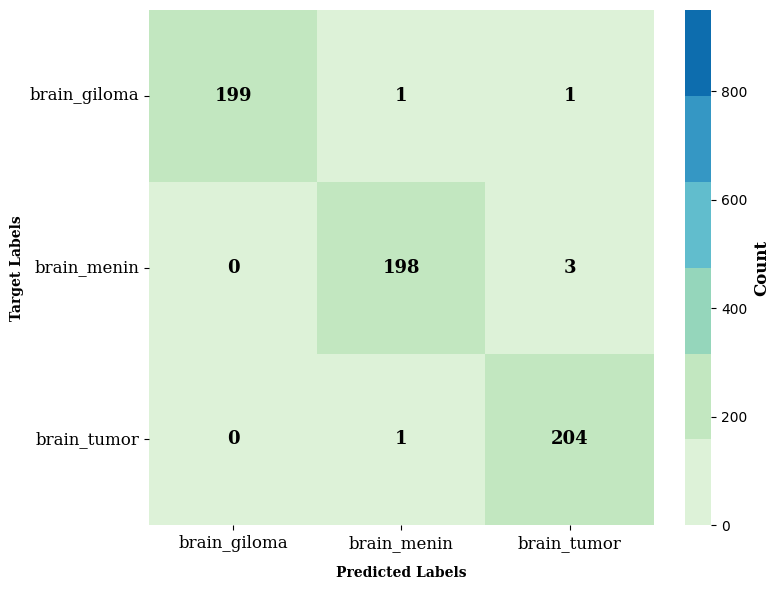

In [21]:
# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8,6))
# Define the custom palette
custom_palette = sns.color_palette(palette='GnBu')  # Modify the number based on the number of classes in the dataset

# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}
font2 = {'family': 'Serif', 'weight': 'bold', 'size': 10}

# Create heatmap with annotations and colormap
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_palette, vmin=0, vmax=950,
                      xticklabels=['brain_giloma', 'brain_menin', 'brain_tumor'], 
                      yticklabels=['brain_giloma', 'brain_menin', 'brain_tumor'],
                      annot_kws={"family": "Serif", 'color':'black', 'weight': 'bold', 'size': 13})

# Set x and y labels with the custom font dictionary
heatmap.set_xlabel('Predicted Labels', fontdict=font2)
heatmap.set_ylabel('Target Labels', fontdict=font2)

# Set font properties for tick labels on both axes
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontname='Serif', fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontname='Serif', fontsize=12)

# Create a color bar to indicate the scale
cbar = heatmap.collections[0].colorbar
cbar.set_label('Count', fontdict=font)
cbar.ax.tick_params(labelsize=10)

# Adjust padding between x-axis label and x-axis ticks
plt.gca().xaxis.labelpad = 10  # Change the value as needed to adjust the space
plt.xticks(rotation=0)
plt.yticks(rotation=0)

# Adjust layout to prevent cropping
plt.tight_layout()

# Save as pdf format
plt.savefig('/kaggle/working/ResNet50.pdf')
plt.show()


In [22]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess the image
img_path = "/kaggle/working/test/brain_glioma/brain_glioma_0571.jpg"  # Replace with the path to your image
img = image.load_img(img_path, target_size=(256, 256))  # Adjust target_size according to your model input size (256, 256)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Create batch dimension
img_array = tf.keras.applications.resnet50.preprocess_input(img_array)  # Adjust preprocessing based on your model


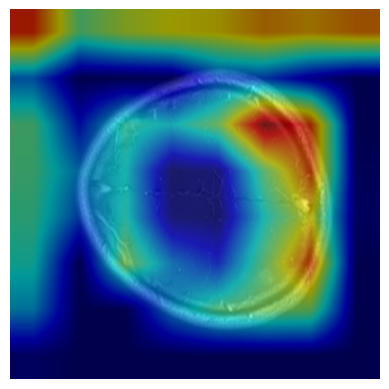

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Model
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Function to generate Grad-CAM heatmap
def generate_gradcam(model, img_array, last_conv_layer_name):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if isinstance(predictions, list):
            predictions = predictions[0]  # Access the first output if it's a list
        loss = predictions[:, tf.argmax(predictions[0])]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    conv_outputs = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(conv_outputs)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = cv2.resize(heatmap.numpy(), (img_array.shape[2], img_array.shape[1]))  # Resize heatmap to image size
    return heatmap

# Function to overlay the heatmap on the original image
def overlay_heatmap_on_image(img_path, heatmap, alpha=0.6):
    img = cv2.imread(img_path)
    
    # Ensure the heatmap and the image have the same number of channels
    if len(img.shape) == 2:  # Grayscale image
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    
    # Resize the heatmap to match the image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert heatmap to 3 channels
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Overlay the heatmap on the original image
    superimposed_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Example usage for Grad-CAM
img_path = "/kaggle/working/test/brain_glioma/brain_glioma_0571.jpg"  # Replace with the path to your image
img = image.load_img(img_path, target_size=(256, 256))  # Adjust target_size according to your model input size (256, 256)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Create batch dimension
img_array = tf.keras.applications.resnet50.preprocess_input(img_array)  # Adjust preprocessing based on your model

last_conv_layer_name = "conv5_block3_out"  # Adjust if necessary

heatmap = generate_gradcam(loaded_model, img_array, last_conv_layer_name)
overlay_heatmap_on_image(img_path, heatmap)


In [24]:
def generate_gradcam_plus_plus(model, img_array, last_conv_layer_name):
    grad_model = Model(inputs=[model.inputs], outputs=[model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if isinstance(predictions, list):
            predictions = predictions[0]  # Access the first output if it's a list
        loss = predictions[:, tf.argmax(predictions[0])]

    grads = tape.gradient(loss, conv_outputs)
    grads_squared = tf.square(grads)
    grads_cubed = tf.pow(grads, 3)

    sum_grads = tf.reduce_sum(conv_outputs, axis=(1, 2))
    alpha_num = grads_squared
    alpha_denom = grads_squared * 2.0 + sum_grads * grads_cubed
    alphas = alpha_num / (alpha_denom + tf.keras.backend.epsilon())
    
    weights = tf.reduce_sum(alphas * tf.maximum(grads, 0), axis=(1, 2))

    conv_outputs = conv_outputs[0]
    weighted_sum = conv_outputs @ weights[..., tf.newaxis]
    heatmap = tf.squeeze(weighted_sum)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = cv2.resize(heatmap.numpy(), (img_array.shape[2], img_array.shape[1]))  # Resize heatmap to image size
    return heatmap


In [25]:
def generate_scorecam(model, img_array, last_conv_layer_name, alpha=0.5):
    grad_model = Model(inputs=[model.inputs], outputs=[model.get_layer(last_conv_layer_name).output])
    
    conv_outputs = grad_model(img_array)
    conv_outputs = conv_outputs[0]
    
    heatmap = np.zeros((img_array.shape[1], img_array.shape[2]), dtype=np.float32)  # Initialize heatmap with image size
    
    for i in range(conv_outputs.shape[-1]):
        upsampled_output = cv2.resize(conv_outputs[..., i].numpy(), (img_array.shape[2], img_array.shape[1]))
        upsampled_output = np.expand_dims(upsampled_output, axis=-1)  # Expand to make it single-channel
        
        # Create a 3-channel version of the upsampled output for prediction
        upsampled_output_rgb = np.repeat(upsampled_output, 3, axis=-1)
        
        # No need to preprocess again since the image is already normalized and in the correct format
        score = model.predict(np.expand_dims(upsampled_output_rgb, axis=0))
        class_score = score[:, tf.argmax(score[0])]  # Get the score of the predicted class
        
        # Resize class_score to the original image size
        resized_score = cv2.resize(class_score, (img_array.shape[2], img_array.shape[1]))
        
        heatmap += resized_score * upsampled_output[..., 0]

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)  # Normalize the heatmap
    return heatmap


In [26]:
def generate_layercam(model, img_array, last_conv_layer_name):
    grad_model = Model(inputs=[model.inputs], outputs=[model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if isinstance(predictions, list):
            predictions = predictions[0]  # Access the first output if it's a list
        loss = predictions[:, tf.argmax(predictions[0])]

    grads = tape.gradient(loss, conv_outputs)
    grads = tf.maximum(grads, 0)

    conv_outputs = conv_outputs[0]
    weights = grads / (tf.reduce_sum(grads, axis=(0, 1, 2), keepdims=True) + tf.keras.backend.epsilon())

    weighted_conv = conv_outputs * weights
    heatmap = tf.reduce_sum(weighted_conv, axis=-1)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = cv2.resize(heatmap.numpy(), (img_array.shape[2], img_array.shape[1]))  # Resize heatmap to image size
    return heatmap


In [27]:
def overlay_heatmap_on_image(img_path, heatmap, alpha=0.6):
    img = cv2.imread(img_path)

    # Ensure the heatmap is a valid NumPy array
    if not isinstance(heatmap, np.ndarray):
        heatmap = heatmap.numpy()

    # Handle the case where the heatmap has multiple channels
    if len(heatmap.shape) == 3 and heatmap.shape[2] > 1:
        heatmap = np.mean(heatmap, axis=-1)  # Average across the channels to create a 2D heatmap

    # Now heatmap should be a 2D array
    heatmap = np.uint8(255 * heatmap)

    # Ensure the image and heatmap have the same number of channels
    if len(img.shape) == 2:  # Grayscale image
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # Resize the heatmap to match the image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Apply the color map
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Overlay the heatmap on the original image
    superimposed_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


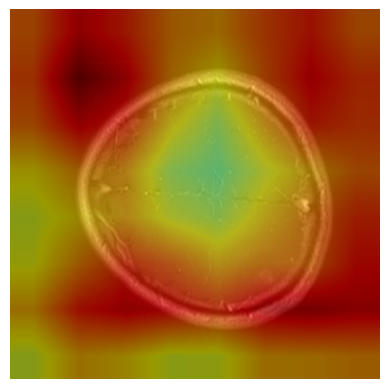

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━

In [ ]:
# Grad-CAM++
heatmap_gradcam_pp = generate_gradcam_plus_plus(loaded_model, img_array, last_conv_layer_name)
overlay_heatmap_on_image(img_path, heatmap_gradcam_pp)

# Score-CAM
heatmap_scorecam = generate_scorecam(loaded_model, img_array, last_conv_layer_name)
overlay_heatmap_on_image(img_path, heatmap_scorecam)

# Layer-CAM
heatmap_layercam = generate_layercam(loaded_model, img_array, last_conv_layer_name)
overlay_heatmap_on_image(img_path, heatmap_layercam)
